# Capstone Project - The Battle of the Neighborhoods

Introduction: Business Problem 
In this project we will do a comparative study of Sushi places in the New York city based on their location, popularity, ratings and likes. The goal is to list and visualize which areas have great Sushi restaurants and get a feel of the market vibe for sushi restaurants.



In [1]:
#Download all the dependencies that we will need.
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install geopy 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library

!pip install folium
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 92kB 8.8MB/s eta 0:00:011
Libraries imported.


# 1. Download and explore New york City dataset
Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.
We will use the dataset from https://geo.nyu.edu/catalog/nyu_2451_34572

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
#Load and explore the data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [5]:
neighborhoods_data = newyork_data['features']

In [6]:
#Tranform the data into a pandas dataframe
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# fill the dataframe
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

    
    

In [7]:
  # examine the resulting dataframes
    neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)
neighborhoods.shape

The dataframe has 5 boroughs and 306 neighborhoods.


(306, 4)

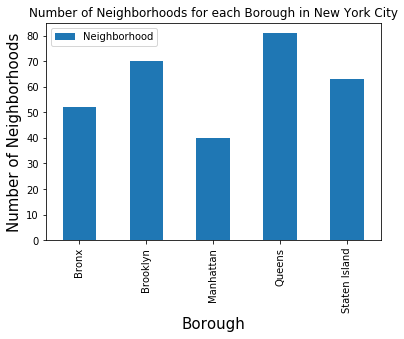

In [9]:
#Let's visualize number of neighborhoods by boroughs
# title
plt.title('Number of Neighborhoods for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of Neighborhoods', fontsize=15)
#giving a bar plot
neighborhoods.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


In [10]:
# visualize a map of neighborhoods within New York City
#Use geopy library to get the latitude and longitude values of Manhattan
address = 'New York, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York are 40.7127281, -74.0060152.


In [11]:
#visualize New York neighborhoods on a map: map of New York with neighborhoods superimposed on top.
# create map of New York using latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

# 2. Explore Neighborhoods in New York using the Four Square API to find all venues for each neighborhood

In [12]:
#Utilize the Foursquare API to explore the neighborhoods and segment them.
CLIENT_ID = 'K05SFB3FEDV2CQBYTPSAM5FE4CGHQVYLXX4IW00VYKHPWZGT' # your Foursquare ID
CLIENT_SECRET = 'T3DT42J4TLVMDNKGWQNR0PIRV4FYCALI0XYLD0EVKPQQ4E0H' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: K05SFB3FEDV2CQBYTPSAM5FE4CGHQVYLXX4IW00VYKHPWZGT
CLIENT_SECRET:T3DT42J4TLVMDNKGWQNR0PIRV4FYCALI0XYLD0EVKPQQ4E0H


In [13]:
#create function to get 100 nearby venues in the New York neighborhoods within a radius of 500 meters 
#using the Foursquare API
def getNearbyVenues(names, latitudes, longitudes, borough, radius=500):
    
    venues_list=[]
    for name, lat, lng, borough in zip(names, latitudes, longitudes, borough):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
          
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [14]:
#call the function to get 100 venues within 500 meters radius of neighborhoods within New York
newyork_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],
                                   borough=neighborhoods['Borough']
                                  )


Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [15]:
#review resulting dataframe
print(newyork_venues.shape)
newyork_venues.head()

(9759, 9)


Borough Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0   Bronx    Wakefield              40.894705              -73.847201   
1   Bronx    Wakefield              40.894705              -73.847201   
2   Bronx    Wakefield              40.894705              -73.847201   
3   Bronx    Wakefield              40.894705              -73.847201   
4   Bronx    Wakefield              40.894705              -73.847201   

                         ID             Venue  Venue Latitude  \
0  4c537892fd2ea593cb077a28  Lollipops Gelato       40.894123   
1  4c783cef3badb1f7e4244b54  Carvel Ice Cream       40.890487   
2  5d5f5044d0ae1c0008f043c3         Walgreens       40.896528   
3  4d6af9426107f04dedeb297a          Rite Aid       40.896649   
4  4c25c212f1272d7f836385c5           Dunkin'       40.890459   

   Venue Longitude  Venue Category  
0       -73.845892    Dessert Shop  
1       -73.848568  Ice Cream Shop  
2       -73.844700        Pharmacy  
3       -73.844846        Pharmacy  
4       -73.849089      Donut Shop

# 3. Analyze Each Neighborhood for sushi restaurants

In [21]:
#slice the dataframe listing venue categories that contain "sushi"
ny_sushidata = newyork_venues[newyork_venues['Venue Category'].str.contains("Sushi")].reset_index(drop=True)
ny_sushidata.head()
ny_sushidata



Borough               Neighborhood  Neighborhood Latitude  \
0            Bronx             Pelham Parkway              40.857413   
1            Bronx            North Riverdale              40.908543   
2         Brooklyn                  Bay Ridge              40.625801   
3         Brooklyn                  Bay Ridge              40.625801   
4         Brooklyn                Bensonhurst              40.611009   
5         Brooklyn                Bensonhurst              40.611009   
6         Brooklyn                 Greenpoint              40.730201   
7         Brooklyn                 Greenpoint              40.730201   
8         Brooklyn                 Greenpoint              40.730201   
9         Brooklyn             Brighton Beach              40.576825   
10        Brooklyn             Brighton Beach              40.576825   
11        Brooklyn              Crown Heights              40.670829   
12        Brooklyn            Windsor Terrace              40.656946   
13        Brooklyn           Prospect Heights              40.676822   
14        Brooklyn           Brooklyn Heights              40.695864   
15        Brooklyn                Cobble Hill              40.687920   
16        Brooklyn            Carroll Gardens              40.680540   
17        Brooklyn                    Gowanus              40.673931   
18        Brooklyn                 Bath Beach              40.599519   
19        Brooklyn                 Bath Beach              40.599519   
20        Brooklyn               Clinton Hill              40.693229   
21        Brooklyn               Clinton Hill              40.693229   
22        Brooklyn                Boerum Hill              40.685683   
23        Brooklyn  Prospect Lefferts Gardens              40.658420   
24        Brooklyn  Prospect Lefferts Gardens              40.658420   
25        Brooklyn                 South Side              40.710861   
26        Brooklyn              Ocean Parkway              40.613060   
27        Brooklyn              Fort Hamilton              40.614768   
28       Manhattan         Washington Heights              40.851903   
29       Manhattan           Hamilton Heights              40.823604   
30       Manhattan           Hamilton Heights              40.823604   
31       Manhattan             Manhattanville              40.816934   
32       Manhattan            Upper East Side              40.775639   
33       Manhattan            Upper East Side              40.775639   
34       Manhattan                  Yorkville              40.775930   
35       Manhattan                  Yorkville              40.775930   
36       Manhattan                  Yorkville              40.775930   
37       Manhattan                  Yorkville              40.775930   
38       Manhattan                 Lenox Hill              40.768113   
39       Manhattan                 Lenox Hill              40.768113   
40       Manhattan                 Lenox Hill              40.768113   
41       Manhattan                 Lenox Hill              40.768113   
42       Manhattan            Upper West Side              40.787658   
43       Manhattan                    Midtown              40.754691   
44       Manhattan                Murray Hill              40.748303   
45       Manhattan                Murray Hill              40.748303   
46       Manhattan                Murray Hill              40.748303   
47       Manhattan          Greenwich Village              40.726933   
48       Manhattan          Greenwich Village              40.726933   
49       Manhattan          Greenwich Village              40.726933   
50       Manhattan                    Tribeca              40.721522   
51       Manhattan                       Soho              40.722184   
52       Manhattan               West Village              40.734434   
53       Manhattan                   Gramercy              40.737210   
54          Queens                    Astoria      

In [17]:
ny_sushidata.shape

(106, 9)

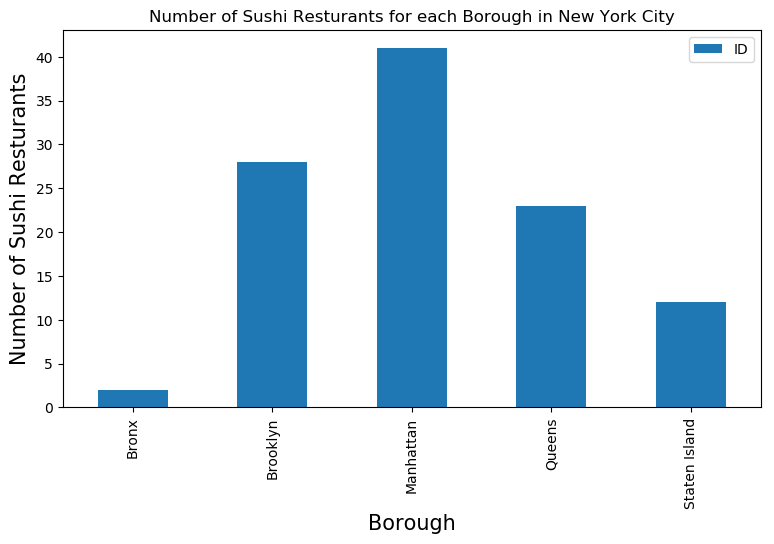

In [18]:
#list the distribution of Sushi restaurants across New York City by borough
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Sushi Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of Sushi Resturants', fontsize=15)
#giving a bar plot
ny_sushidata.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

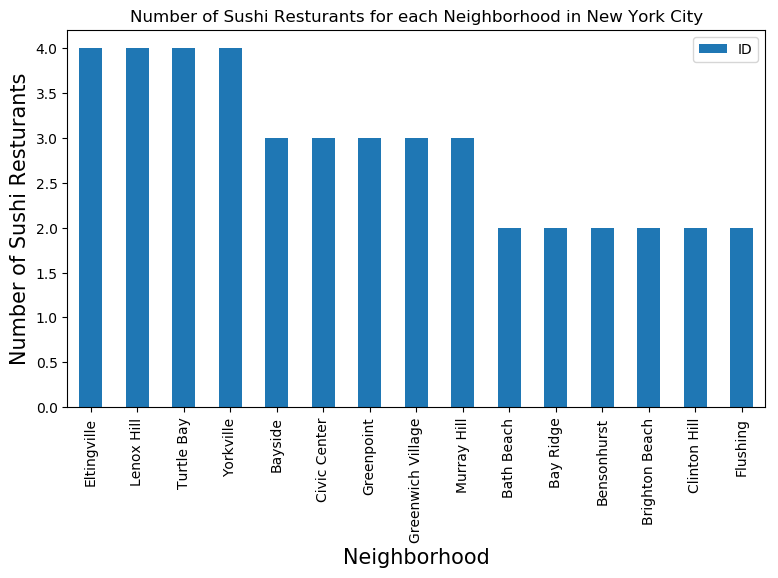

In [19]:
# Let's look at the dstribution of Sushi restaurants by Neighborhoods
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Sushi Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Number of Sushi Resturants', fontsize=15)
#giving a bar plot
ny_sushidata.groupby('Neighborhood')['ID'].count().nlargest(15).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [22]:
ny_sushidata[ny_sushidata['Neighborhood']=='Eltingville']

Borough Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
76  Staten Island  Eltingville              40.542231              -74.164331   
77  Staten Island  Eltingville              40.542231              -74.164331   
78  Staten Island  Eltingville              40.542231              -74.164331   
79  Staten Island  Eltingville              40.542231              -74.164331   

                          ID                  Venue  Venue Latitude  \
76  4bc0e24bb492d13a2417a560             Kiku Sushi       40.544350   
77  4bda0cbfaae4ef3b3dcc6ec6  TOMO Japanese Cuisine       40.542835   
78  4bfd7488f7c82d7fb4368e04             East Sushi       40.545171   
79  4c014226cf3aa59373b7ccb0              Aka Sushi       40.545318   

    Venue Longitude    Venue Category  
76       -74.165691  Sushi Restaurant  
77       -74.165578  Sushi Restaurant  
78       -74.161357  Sushi Restaurant  
79       -74.160197  Sushi Restaurant

In [27]:
#Let's visualize these places on a map
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) 


# add popular spots to the map as blue circle markers
for lat, lng, label in zip(ny_sushidata['Venue Latitude'], ny_sushidata['Venue Longitude'], ny_sushidata['Venue']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map



In [34]:
#Define a function to get venue details like count , rating , tip counts for a given venue id. This will be used for ranking.
def get_venue_details(venue_id):

    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [33]:
ny_sushirankingdata = ny_sushidata[['Borough', 'Neighborhood', 'ID','Venue']]
ny_sushirankingdata



Borough               Neighborhood                        ID  \
0            Bronx             Pelham Parkway  4c45c922f97fbe9a9e02bd30   
1            Bronx            North Riverdale  4baa9c97f964a52088793ae3   
2         Brooklyn                  Bay Ridge  519432c7498eae4af99449fd   
3         Brooklyn                  Bay Ridge  4a73a072f964a520fbdc1fe3   
4         Brooklyn                Bensonhurst  4b3fde9af964a520eeb025e3   
5         Brooklyn                Bensonhurst  4ad3ad99f964a52092e520e3   
6         Brooklyn                 Greenpoint  5b809669b9a5a8002c0c871b   
7         Brooklyn                 Greenpoint  49d798e9f964a520395d1fe3   
8         Brooklyn                 Greenpoint  5a98492083e3807c830d584e   
9         Brooklyn             Brighton Beach  4ac43a28f964a520799e20e3   
10        Brooklyn             Brighton Beach  4a5f5918f964a5206dbf1fe3   
11        Brooklyn              Crown Heights  59528c41fd16bb5b31acf40b   
12        Brooklyn            Windsor Terrace  4aa058fcf964a520433f20e3   
13        Brooklyn           Prospect Heights  49f50c9ff964a5208a6b1fe3   
14        Brooklyn           Brooklyn Heights  4b6b6ad0f964a52066072ce3   
15        Brooklyn                Cobble Hill  49e9230ef964a520cf651fe3   
16        Brooklyn            Carroll Gardens  49e9230ef964a520cf651fe3   
17        Brooklyn                    Gowanus  500f4976011c45bfb43c5e3f   
18        Brooklyn                 Bath Beach  4a309ae6f964a52084991fe3   
19        Brooklyn                 Bath Beach  4c16c0f45e88c9287ca82466   
20        Brooklyn               Clinton Hill  4a9b40b0f964a520d83420e3   
21        Brooklyn               Clinton Hill  50b103bce4b09d9e07b9c52d   
22        Brooklyn                Boerum Hill  58d7f76b0393cc26f48858c6   
23        Brooklyn  Prospect Lefferts Gardens  56f0a695cd1075cd28419327   
24        Brooklyn  Prospect Lefferts Gardens  4a84a298f964a5202dfd1fe3   
25        Brooklyn                 South Side  423e0e80f964a52048201fe3   
26        Brooklyn              Ocean Parkway  4cf5b3d5d3a8a1cdf95bcd43   
27        Brooklyn              Fort Hamilton  4ccc513fee23a1431b021ea8   
28       Manhattan         Washington Heights  4a4a642cf964a520bdab1fe3   
29       Manhattan           Hamilton Heights  5674592d498e85f07427e61b   
30       Manhattan           Hamilton Heights  577875a2498e0a21a3ef1a97   
31       Manhattan             Manhattanville  51573e61e4b06ee00f00307b   
32       Manhattan            Upper East Side  5a8c6e6fb6b04b2d4e648ccb   
33       Manhattan            Upper East Side  4aa29d9cf964a520f94120e3   
34       Manhattan                  Yorkville  4a0d5a23f964a52077751fe3   
35       Manhattan                  Yorkville  4a9b12eef964a5204e3420e3   
36       Manhattan                  Yorkville  49c5558cf964a520f6561fe3   
37       Manhattan                  Yorkville  4bce0d1129d4b71315dca7dc   
38       Manhattan                 Lenox Hill  593747b672475054e94bd3d4   
39       Manhattan                 Lenox Hill  59a0a55725fb7b0552213ca6   
40       Manhattan                 Lenox Hill  548f7d37498e7976a22eada4   
41       Manhattan                 Lenox Hill  501adf11e4b0d225f8788a03   
42       Manhattan            Upper West Side  4b3ce40ef964a5200b8925e3   
43       Manhattan                    Midtown  595ebd0aee712007dc5ae215   
44       Manhattan                Murray Hill  5b88b22f16ef67002ce49afe   
45       Manhattan                Murray Hill  4a84a19bf964a5202afd1fe3   
46       Manhattan                Murray Hill  4bba3cf87421a593728fc340   
47       Manhattan          Greenwich Village  555e7399498eccd4b34fe416   
48       Manhattan          Greenwich Village  3fd66200f964a5200eea1ee3   
49       Manhattan          Greenwich Village  5c6c6715f709c1002cd49290   
50       Manhattan                    Tribeca  4aad744bf964a520606020e3   
51       Manhattan                       Soho  5c6c6715f709c1002cd49290   
52       Manhattan               Wes

In [36]:
# Get ranking for each sushi restaurant
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
sushi_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in ny_sushirankingdata.values.tolist():
    Borough,Neighborhood,ID,Venue=row
    try:
        venue_details=get_venue_details(ID)
        #print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for venue=',Venue)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(ny_sushidata),')','processed')
    sushi_rest_stats_ny = sushi_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

( 1 / 106 ) processed
( 2 / 106 ) processed
( 3 / 106 ) processed
( 4 / 106 ) processed
( 5 / 106 ) processed
( 6 / 106 ) processed
( 7 / 106 ) processed
( 8 / 106 ) processed
( 9 / 106 ) processed
( 10 / 106 ) processed
( 11 / 106 ) processed
No data available for venue= Noribar
( 12 / 106 ) processed
( 13 / 106 ) processed
( 14 / 106 ) processed
( 15 / 106 ) processed
( 16 / 106 ) processed
( 17 / 106 ) processed
( 18 / 106 ) processed
( 19 / 106 ) processed
No data available for venue= Kagetsu
( 20 / 106 ) processed
( 21 / 106 ) processed
( 22 / 106 ) processed
( 23 / 106 ) processed
( 24 / 106 ) processed
( 25 / 106 ) processed
( 26 / 106 ) processed
No data available for venue= Sushi Royale
( 27 / 106 ) processed
( 28 / 106 ) processed
( 29 / 106 ) processed
( 30 / 106 ) processed
( 31 / 106 ) processed
( 32 / 106 ) processed
( 33 / 106 ) processed
( 34 / 106 ) processed
( 35 / 106 ) processed
( 36 / 106 ) processed
( 37 / 106 ) processed
( 38 / 106 ) processed
( 39 / 106 ) proces

In [37]:
sushi_rest_stats_ny

Borough               Neighborhood                        ID  \
0            Bronx             Pelham Parkway  4c45c922f97fbe9a9e02bd30   
1            Bronx            North Riverdale  4baa9c97f964a52088793ae3   
2         Brooklyn                  Bay Ridge  519432c7498eae4af99449fd   
3         Brooklyn                  Bay Ridge  4a73a072f964a520fbdc1fe3   
4         Brooklyn                Bensonhurst  4b3fde9af964a520eeb025e3   
5         Brooklyn                Bensonhurst  4ad3ad99f964a52092e520e3   
6         Brooklyn                 Greenpoint  5b809669b9a5a8002c0c871b   
7         Brooklyn                 Greenpoint  49d798e9f964a520395d1fe3   
8         Brooklyn                 Greenpoint  5a98492083e3807c830d584e   
9         Brooklyn             Brighton Beach  4ac43a28f964a520799e20e3   
10        Brooklyn             Brighton Beach  4a5f5918f964a5206dbf1fe3   
11        Brooklyn              Crown Heights                         0   
12        Brooklyn            Windsor Terrace  4aa058fcf964a520433f20e3   
13        Brooklyn           Prospect Heights  49f50c9ff964a5208a6b1fe3   
14        Brooklyn           Brooklyn Heights  4b6b6ad0f964a52066072ce3   
15        Brooklyn                Cobble Hill  49e9230ef964a520cf651fe3   
16        Brooklyn            Carroll Gardens  49e9230ef964a520cf651fe3   
17        Brooklyn                    Gowanus  500f4976011c45bfb43c5e3f   
18        Brooklyn                 Bath Beach  4a309ae6f964a52084991fe3   
19        Brooklyn                 Bath Beach                         0   
20        Brooklyn               Clinton Hill  4a9b40b0f964a520d83420e3   
21        Brooklyn               Clinton Hill  50b103bce4b09d9e07b9c52d   
22        Brooklyn                Boerum Hill  58d7f76b0393cc26f48858c6   
23        Brooklyn  Prospect Lefferts Gardens  56f0a695cd1075cd28419327   
24        Brooklyn  Prospect Lefferts Gardens  4a84a298f964a5202dfd1fe3   
25        Brooklyn                 South Side  423e0e80f964a52048201fe3   
26        Brooklyn              Ocean Parkway                         0   
27        Brooklyn              Fort Hamilton  4ccc513fee23a1431b021ea8   
28       Manhattan         Washington Heights  4a4a642cf964a520bdab1fe3   
29       Manhattan           Hamilton Heights  5674592d498e85f07427e61b   
30       Manhattan           Hamilton Heights  577875a2498e0a21a3ef1a97   
31       Manhattan             Manhattanville  51573e61e4b06ee00f00307b   
32       Manhattan            Upper East Side  5a8c6e6fb6b04b2d4e648ccb   
33       Manhattan            Upper East Side  4aa29d9cf964a520f94120e3   
34       Manhattan                  Yorkville  4a0d5a23f964a52077751fe3   
35       Manhattan                  Yorkville  4a9b12eef964a5204e3420e3   
36       Manhattan                  Yorkville  49c5558cf964a520f6561fe3   
37       Manhattan                  Yorkville  4bce0d1129d4b71315dca7dc   
38       Manhattan                 Lenox Hill  593747b672475054e94bd3d4   
39       Manhattan                 Lenox Hill  59a0a55725fb7b0552213ca6   
40       Manhattan                 Lenox Hill  548f7d37498e7976a22eada4   
41       Manhattan                 Lenox Hill  501adf11e4b0d225f8788a03   
42       Manhattan            Upper West Side  4b3ce40ef964a5200b8925e3   
43       Manhattan                    Midtown  595ebd0aee712007dc5ae215   
44       Manhattan                Murray Hill  5b88b22f16ef67002ce49afe   
45       Manhattan                Murray Hill  4a84a19bf964a5202afd1fe3   
46       Manhattan                Murray Hill  4bba3cf87421a593728fc340   
47       Manhattan          Greenwich Village  555e7399498eccd4b34fe416   
48       Manhattan          Greenwich Village  3fd66200f964a5200eea1ee3   
49       Manhattan          Greenwich Village  5c6c6715f709c1002cd49290   
50       Manhattan                    Tribeca  4aad744bf964a520606020e3   
51       Manhattan                       Soho  5c6c6715f709c1002cd49290   
52       Manhattan               Wes

In [38]:
# Save the ranking data to csv file
sushi_rest_stats_ny.to_csv('sushi_rest_stats_ny.csv', index=False)

In [39]:
sushi_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 7 columns):
Borough         106 non-null object
Neighborhood    106 non-null object
ID              106 non-null object
Name            106 non-null object
Likes           106 non-null object
Rating          106 non-null float64
Tips            106 non-null object
dtypes: float64(1), object(6)
memory usage: 5.9+ KB


In [40]:
#values like Likes, Tips should be converted to float for further analysis
sushi_rest_stats_ny['Likes']=sushi_rest_stats_ny['Likes'].astype('float64')
sushi_rest_stats_ny['Tips']=sushi_rest_stats_ny['Tips'].astype('float64')
sushi_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 7 columns):
Borough         106 non-null object
Neighborhood    106 non-null object
ID              106 non-null object
Name            106 non-null object
Likes           106 non-null float64
Rating          106 non-null float64
Tips            106 non-null float64
dtypes: float64(3), object(4)
memory usage: 5.9+ KB


In [41]:
# Resturant with maximum Likes
sushi_rest_stats_ny.iloc[sushi_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                  Turtle Bay
ID              450972f5f964a5203d391fe3
Name                        Sushi Yasuda
Likes                                599
Rating                               8.7
Tips                                 260
Name: 93, dtype: object

In [42]:

# Resturant with maximum Rating
sushi_rest_stats_ny.iloc[sushi_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                    Flatiron
ID              5a0e475b018cbb6a2196479e
Name                        Sushi By Bou
Likes                                 78
Rating                               9.4
Tips                                  13
Name: 98, dtype: object

In [43]:
# Resturant with maximum Tips
sushi_rest_stats_ny.iloc[sushi_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                  Turtle Bay
ID              450972f5f964a5203d391fe3
Name                        Sushi Yasuda
Likes                                599
Rating                               8.7
Tips                                 260
Name: 93, dtype: object

In [44]:
#Let's visualize neighborhood with maximum average rating of restaurants
ny_neighborhood_stats=sushi_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [45]:
#top neighborhoods with top average rating of Indian resturants
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

Neighborhood  Average Rating
19              Flatiron        9.400000
53                  Soho        9.200000
38               Midtown        9.200000
48      Prospect Heights        9.000000
21  Forest Hills Gardens        9.000000
26     Greenwich Village        8.966667
58               Tribeca        8.700000
42                  Noho        8.700000
54            South Side        8.700000
56     Sunnyside Gardens        8.700000

In [46]:
#top neighborhoods with top average rating of Indian resturants
ny_borough_stats=sushi_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

Borough  Average Rating
2      Manhattan        8.229268
0          Bronx        7.700000
3         Queens        7.043478
1       Brooklyn        6.446429
4  Staten Island        6.075000

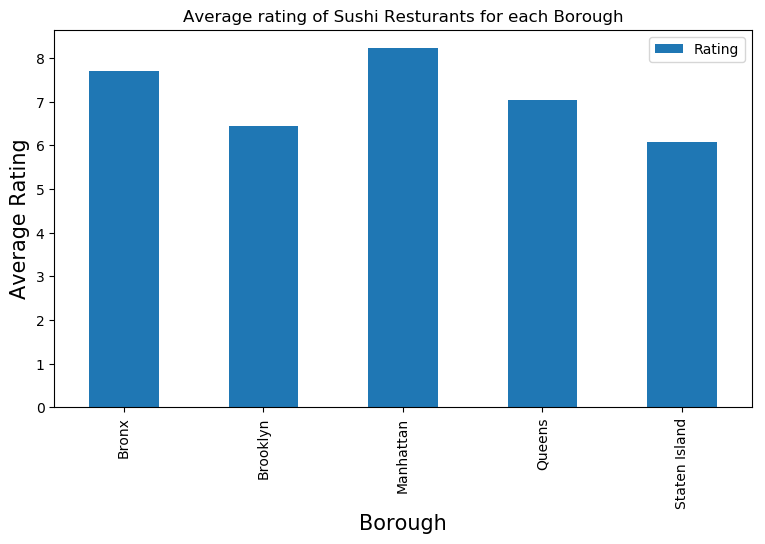

In [47]:
#let's visualize it
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Sushi Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
sushi_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [56]:
#We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [57]:
ny_neighborhood_stats

Neighborhood  Average Rating
19              Flatiron             9.4
21  Forest Hills Gardens             9.0
38               Midtown             9.2
48      Prospect Heights             9.0
53                  Soho             9.2

In [58]:
#Join this dataset to original new york data to get lat and long
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,neighborhoods, on='Neighborhood')

In [59]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [60]:
ny_neighborhood_stats

Borough          Neighborhood   Latitude  Longitude  Average Rating
0  Manhattan              Flatiron  40.739673 -73.990947             9.4
1     Queens  Forest Hills Gardens  40.714611 -73.841022             9.0
2  Manhattan               Midtown  40.754691 -73.981669             9.2
3   Brooklyn      Prospect Heights  40.676822 -73.964859             9.0
4  Manhattan                  Soho  40.722184 -74.000657             9.2

In [63]:
## Show this data on a map: create map and display it
ny_map = folium.Map(location=[latitude, longitude], zoom_start=12)

In [64]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the sushi restaurants and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [65]:
#add a new field to dataframe for labeling purpose
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [66]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [88]:
!wget --quiet 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON' -O 'Borough Boundaries.geojson'
print('GeoJSON file downloaded!')
with open('Borough Boundaries.geojson') as file:    
    nyb = json.load(file)
    
nyb


GeoJSON file downloaded!


{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'boro_code': '2',
    'boro_name': 'Bronx',
    'shape_area': '1186612478.27',
    'shape_leng': '462958.187578'},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[-73.89680883223774, 40.79580844515979],
       [-73.89693872998792, 40.79563587285357],
       [-73.89723603843939, 40.79572003753707],
       [-73.89796839783742, 40.795644839161994],
       [-73.89857332665558, 40.7960691402596],
       [-73.89895261832527, 40.796227852579634],
       [-73.89919434249981, 40.79650245601822],
       [-73.89852052071471, 40.796936194189776],
       [-73.89788253240185, 40.79711653214705],
       [-73.89713149795642, 40.79679807772831],
       [-73.89678526341234, 40.796329166487105],
       [-73.89680883223774, 40.79580844515979]]],
     [[[-73.88885148496334, 40.798706328958765],
       [-73.88860021869873, 40.798650985918705],
       [-73.8885856250733, 40.798706072297094],
       [-73.888213488

In [89]:
#Lets Visualize Boroughs based on average Rating
ny_map = folium.Map(location=[latitude, longitude], zoom_start=12)
ny_geo = nyb

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
ny_map
# display map
# as this is huge map data , we will save it to a file
#ny_map.save('borough_rating.html')